# Overview

This exercise demonstrates how TEMPO data can be used to track smoke and dust and perform quantitative analysis.

**Notebook Author / Affiliation**

* Author: Carl Malings / NASA ARSET
* This notebook is based on examples from the [ASDC Data and User Services Github](https://github.com/nasa/ASDC_Data_and_User_Services).

## Package Installation and Setup

*Instructions*

* Run the cell below to install the non-standard packages required for this exercise.

In [1]:
!pip install --quiet harmony-py cartopy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.5 MB/s eta 0:00:00


*Instructions*

* Run the code cell below to import the required packages.

In [16]:
# Downloading TEMPO data
import datetime as dt
import getpass
import os
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

# Opening TEMPO data files
import xarray as xr

# Creating graphics
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

# Working with data tables
import pandas as pd

# Download TEMPO Data

The first part of this exercise will be to download the TEMPO NO2, HCHO and Aerosol Index data for the region and time period of interest.

**Region of Interest**: South-Central US (latitude 30 to 40, longitude -102 to -92)

**Time of Interest**: March 14, 2025 (03/14/2025 13:00 UTC to 03/15/2025 00:00 UTC)

*Instructions*

* Run the cell below and enter your Earthdata credentials to prepare for data downloading

In [3]:
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Username:carl_malings
··········


## Get TEMPO Level-3 NO2 Data

The below code is copied from previous examples of downloading TEMPO data. You will use it to download TEMPO Level-3 NO2 data for a region and time period of inerest.

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 NO2 data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `RoI`, `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [ ]:
# This list will save the bounding box limits for later use:
RoI = [-102, 30, -92, 40]

# Structure the request:
request_no2 = Request(
    collection=Collection(id='C2930763263-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2025, 3, 14, 13),
        'stop': dt.datetime(2025, 3, 15, 0)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_no2.is_valid()

True

*Submit and monitor the request*

In [ ]:
job_id_no2 = harmony_client.submit(request_no2)
print(f"jobID = {job_id_no2}")

harmony_client.wait_for_processing(job_id_no2, show_progress=True)

jobID = a007cf84-9b37-4469-9dea-c7c91d55b7d9


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [ ]:
download_dir = os.path.expanduser("~/tempo_data_smoke_and_dust_exercise")
os.makedirs(download_dir, exist_ok=True)

results_no2 = harmony_client.download_all(job_id_no2, directory=download_dir)
all_results_stored_no2 = [f.result() for f in results_no2]

print(f"Number of files: {len(all_results_stored_no2)}")

/root/tempo_data_smoke_and_dust_exercise/106002917_TEMPO_NO2_L3_V03_20250314T123754Z_S003_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002918_TEMPO_NO2_L3_V03_20250314T131802Z_S004_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002919_TEMPO_NO2_L3_V03_20250314T141802Z_S005_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002920_TEMPO_NO2_L3_V03_20250314T151802Z_S006_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002921_TEMPO_NO2_L3_V03_20250314T161802Z_S007_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002922_TEMPO_NO2_L3_V03_20250314T171802Z_S008_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002923_TEMPO_NO2_L3_V03_20250314T181802Z_S009_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002925_TEMPO_NO2_L3_V03_20250314T201802Z_S011_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002924_TEMPO_NO2_L3_V03_20250314T191802Z_S010_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106002926_TEMPO_NO2_L3_

*Open the files and combine into a single Dataset*

<details>

Note that there is a slightly different structure to this code than seen in previous examples. The dictionary `variables_to_keep_and_rename` provides a complete list of the variables to keep and the new names they will be assigned. This makes it more straightforward to change what variables are kept, so that the same code can be re-used more easily for the other TEMPO products.

</details>

In [ ]:
# Define which variables to keep and rename:
variables_to_keep_and_rename = {'product/vertical_column_troposphere':'no2_vertical_column_troposphere',
                                'product/main_data_quality_flag':'no2_qc_flag',
                                'geolocation/solar_zenith_angle':'no2_sza',
                                'support_data/eff_cloud_fraction':'no2_cloud_fraction'
                                }

# Create a dictionary to store the data:
data_dictionary = {variable:[] for variable in variables_to_keep_and_rename.keys()}

# Loop through the result files:
for result_file in sorted(all_results_stored_no2):
    # Loop throuch variables:
    for variable in variables_to_keep_and_rename.keys():
        # For each file and variable, add the data from that file to the appropriate list in the dictionary:
        data_dictionary[variable] += [xr.open_datatree(result_file)[variable]]

# Concatenate each list into a Dataset along the time dimenion:
for variable in variables_to_keep_and_rename.keys():
    data_dictionary[variable] = xr.concat(data_dictionary[variable],dim='time')

# Merge the Datasets together:
tempo_data_no2 = xr.merge([data_dictionary[variable] for variable in variables_to_keep_and_rename.keys()])

# Rename the variables
tempo_data_no2 = tempo_data_no2.rename({variable.split('/')[1]:variables_to_keep_and_rename[variable] for variable in variables_to_keep_and_rename.keys()})

# Examine the result:
tempo_data_no2

<xarray.Dataset> Size: 65MB
Dimensions:                          (longitude: 500, latitude: 500, time: 13)
Coordinates:
  * longitude                        (longitude) float32 2kB -102.0 ... -92.01
  * latitude                         (latitude) float32 2kB 30.01 ... 39.99
  * time                             (time) datetime64[ns] 104B 2025-03-14T12...
Data variables:
    no2_vertical_column_troposphere  (time, latitude, longitude) float64 26MB ...
    no2_qc_flag                      (time, latitude, longitude) float32 13MB ...
    no2_sza                          (time, latitude, longitude) float32 13MB ...
    no2_cloud_fraction               (time, latitude, longitude) float32 13MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, and also filter by Solar Zenith Angle (accepting values less than 70) and Cloud Fraction (accepting values less than 0.2)

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [40]:
filter_qa = tempo_data_no2['no2_qc_flag'] <= 1
filter_sza = tempo_data_no2['no2_sza'] < 70
filter_cf = tempo_data_no2['no2_cloud_fraction'] < 0.2

tempo_data_no2_filtered = tempo_data_no2.where(filter_qa & filter_sza & filter_cf).squeeze()

*Plot Maps of Tropospheric Column NO2*

The code below is taken from earlier plotting examples, with slight modifications.

*Instructions*

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

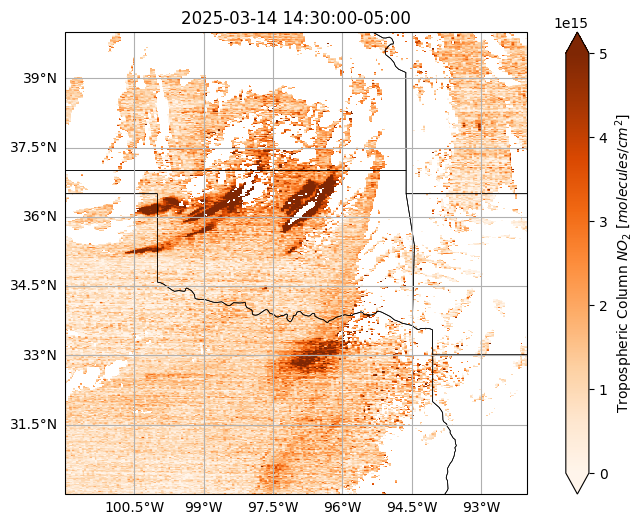

In [44]:
data_proj = ccrs.PlateCarree()

def make_nice_map(axis):
    axis.add_feature(cfeature.STATES.with_scale('50m'), edgecolor="black", linewidth=0.5)
    axis.coastlines(resolution="50m", color="black", linewidth=1.0)

    axis.set_extent([RoI[0], RoI[2], RoI[1], RoI[3]], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2025-03-14 14:30:00',tz='America/Chicago')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot = tempo_data_no2_filtered['no2_vertical_column_troposphere'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('Oranges'), # color scale
    vmin=0, # minimum value
    vmax=5e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $NO_2$ [$molecules/cm^2$]'} # set colorbar label
)

ax.set_title(timestamp_local)

plt.show()

## Get TEMPO Level-3 HCHO Data

Now, download TEMPO Level-3 HCHO data for a region and time period of inerest.

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 HCHO data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [45]:
# Structure the request:
request_hcho = Request(
    collection=Collection(id='C2930761273-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2025, 3, 14, 13),
        'stop': dt.datetime(2025, 3, 15, 0)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_hcho.is_valid()

True

*Submit and monitor the request*

In [46]:
job_id_hcho = harmony_client.submit(request_hcho)
print(f"jobID = {job_id_hcho}")

harmony_client.wait_for_processing(job_id_hcho, show_progress=True)

jobID = c5228230-9bcf-4195-af3b-683ed3efdf9f


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [47]:
results_hcho = harmony_client.download_all(job_id_hcho, directory=download_dir)
all_results_stored_hcho = [f.result() for f in results_hcho]

print(f"Number of files: {len(all_results_stored_hcho)}")

/root/tempo_data_smoke_and_dust_exercise/106003013_TEMPO_HCHO_L3_V03_20250314T123754Z_S003_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003014_TEMPO_HCHO_L3_V03_20250314T131802Z_S004_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003016_TEMPO_HCHO_L3_V03_20250314T151802Z_S006_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003017_TEMPO_HCHO_L3_V03_20250314T161802Z_S007_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003015_TEMPO_HCHO_L3_V03_20250314T141802Z_S005_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003018_TEMPO_HCHO_L3_V03_20250314T171802Z_S008_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003022_TEMPO_HCHO_L3_V03_20250314T211802Z_S012_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003020_TEMPO_HCHO_L3_V03_20250314T191802Z_S010_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003019_TEMPO_HCHO_L3_V03_20250314T181802Z_S009_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003021_TEMP

*Open the files and combine into a single Dataset*

In [49]:
# Define which variables to keep and rename:
variables_to_keep_and_rename = {'product/vertical_column':'hcho_vertical_column',
                                'product/main_data_quality_flag':'hcho_qc_flag',
                                'geolocation/solar_zenith_angle':'hcho_sza',
                                'support_data/eff_cloud_fraction':'hcho_cloud_fraction'
                                }

# Create a dictionary to store the data:
data_dictionary = {variable:[] for variable in variables_to_keep_and_rename.keys()}

# Loop through the result files:
for result_file in sorted(all_results_stored_hcho):
    # Loop throuch variables:
    for variable in variables_to_keep_and_rename.keys():
        # For each file and variable, add the data from that file to the appropriate list in the dictionary:
        data_dictionary[variable] += [xr.open_datatree(result_file)[variable]]

# Concatenate each list into a Dataset along the time dimenion:
for variable in variables_to_keep_and_rename.keys():
    data_dictionary[variable] = xr.concat(data_dictionary[variable],dim='time')

# Merge the Datasets together:
tempo_data_hcho = xr.merge([data_dictionary[variable] for variable in variables_to_keep_and_rename.keys()])

# Rename the variables
tempo_data_hcho = tempo_data_hcho.rename({variable.split('/')[1]:variables_to_keep_and_rename[variable] for variable in variables_to_keep_and_rename.keys()})

# Examine the result:
tempo_data_hcho

<xarray.Dataset> Size: 65MB
Dimensions:               (longitude: 500, latitude: 500, time: 13)
Coordinates:
  * longitude             (longitude) float32 2kB -102.0 -102.0 ... -92.01
  * latitude              (latitude) float32 2kB 30.01 30.03 ... 39.97 39.99
  * time                  (time) datetime64[ns] 104B 2025-03-14T12:38:12.0297...
Data variables:
    hcho_vertical_column  (time, latitude, longitude) float64 26MB 2.48e+16 ....
    hcho_qc_flag          (time, latitude, longitude) float32 13MB 1.0 ... 2.0
    hcho_sza              (time, latitude, longitude) float32 13MB 86.68 ... ...
    hcho_cloud_fraction   (time, latitude, longitude) float32 13MB 0.1358 ......
Attributes:
    long_name:  formaldehyde vertical column
    comment:    formaldehyde vertical column determined from fitted slant col...
    units:      molecules/cm^2

*Apply quality control*

<details>

For this exercise, we will accept Suspect data, and also filter by Solar Zenith Angle (accepting values less than 70) and Cloud Fraction (accepting values less than 0.2)

*Hint:* TEMPO quality flags are:

* `0` = Normal quality (use for analysis)

* `1` = Suspect quality (use with caution)

* `2` = Bad quality (exclude from analysis)

</details>

In [50]:
filter_qa = tempo_data_hcho['hcho_qc_flag'] <= 1
filter_sza = tempo_data_hcho['hcho_sza'] < 70
filter_cf = tempo_data_hcho['hcho_cloud_fraction'] < 0.2

tempo_data_hcho_filtered = tempo_data_hcho.where(filter_qa & filter_sza & filter_cf).squeeze()

*Plot Maps of Column HCHO*

The code below is taken from earlier plotting examples, with slight modifications.

*Instructions*

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

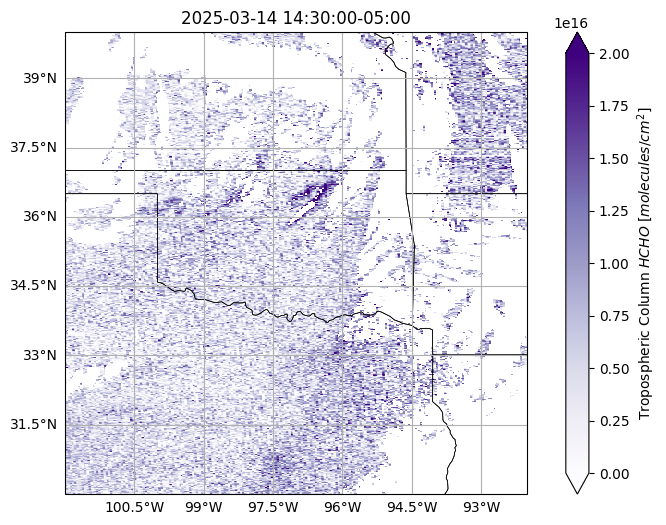

In [54]:
# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2025-03-14 14:30:00',tz='America/Chicago')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot = tempo_data_hcho_filtered['hcho_vertical_column'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('Purples'), # color scale
    vmin=0, # minimum value
    vmax=20e15, # maximum value
    cbar_kwargs={'label':'Tropospheric Column $HCHO$ [$molecules/cm^2$]'} # set colorbar label
)

ax.set_title(timestamp_local)

plt.show()

## Get TEMPO Level-3 Ozone Data

Now, download TEMPO Level-3 Ozone Total Column data for a region and time period of inerest. We need this because these files also contain the UV Aerosol Index data.

*Instructions*

* Modify the code in the next cells to download the TEMPO Level-3 Ozone Total Column data product for the region and time period of interest.

* Run the cells in sequence to download the desired TEMPO data.

<details>

*Hint*: You will need to modify the `Collection id`, `start` and `stop` times.

*Hint*: Use [Earthdata Search](https://search.earthdata.nasa.gov/search) to get the Collection id.

</details>

*Build the request*

In [55]:
# Structure the request:
request_o3tot = Request(
    collection=Collection(id='C2930764281-LARC_CLOUD'),
    temporal={
        'start': dt.datetime(2025, 3, 14, 13),
        'stop': dt.datetime(2025, 3, 15, 0)
    },
    spatial=BBox(RoI[0], RoI[1], RoI[2], RoI[3]),
)

# Check the request is valid:
request_o3tot.is_valid()

True

*Submit and monitor the request*

In [56]:
job_id_o3tot = harmony_client.submit(request_o3tot)
print(f"jobID = {job_id_o3tot}")

harmony_client.wait_for_processing(job_id_o3tot, show_progress=True)

jobID = 58dfda05-b5b1-437e-9792-dfcaeb1e7b94


 [ Processing: 100% ] |###################################################| [|]


*Download the results*

In [57]:
results_o3tot = harmony_client.download_all(job_id_o3tot, directory=download_dir)
all_results_stored_o3tot = [f.result() for f in results_o3tot]

print(f"Number of files: {len(all_results_stored_o3tot)}")

/root/tempo_data_smoke_and_dust_exercise/106003164_TEMPO_O3TOT_L3_V03_20250314T123754Z_S003_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003167_TEMPO_O3TOT_L3_V03_20250314T151802Z_S006_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003165_TEMPO_O3TOT_L3_V03_20250314T131802Z_S004_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003166_TEMPO_O3TOT_L3_V03_20250314T141802Z_S005_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003168_TEMPO_O3TOT_L3_V03_20250314T161802Z_S007_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003169_TEMPO_O3TOT_L3_V03_20250314T171802Z_S008_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003171_TEMPO_O3TOT_L3_V03_20250314T191802Z_S010_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003172_TEMPO_O3TOT_L3_V03_20250314T201802Z_S011_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/106003170_TEMPO_O3TOT_L3_V03_20250314T181802Z_S009_subsetted.nc4
/root/tempo_data_smoke_and_dust_exercise/10600

*Open the files and combine into a single Dataset*

In [59]:
# Define which variables to keep and rename:
variables_to_keep_and_rename = {'product/uv_aerosol_index':'uv_aerosol_index',
                                'geolocation/solar_zenith_angle':'o3_sza',
                                }

# Create a dictionary to store the data:
data_dictionary = {variable:[] for variable in variables_to_keep_and_rename.keys()}

# Loop through the result files:
for result_file in sorted(all_results_stored_o3tot):
    # Loop throuch variables:
    for variable in variables_to_keep_and_rename.keys():
        # For each file and variable, add the data from that file to the appropriate list in the dictionary:
        data_dictionary[variable] += [xr.open_datatree(result_file)[variable]]

# Concatenate each list into a Dataset along the time dimenion:
for variable in variables_to_keep_and_rename.keys():
    data_dictionary[variable] = xr.concat(data_dictionary[variable],dim='time')

# Merge the Datasets together:
tempo_data_uvai = xr.merge([data_dictionary[variable] for variable in variables_to_keep_and_rename.keys()])

# Rename the variables
tempo_data_uvai = tempo_data_uvai.rename({variable.split('/')[1]:variables_to_keep_and_rename[variable] for variable in variables_to_keep_and_rename.keys()})

# Examine the result:
tempo_data_uvai

<xarray.Dataset> Size: 26MB
Dimensions:           (longitude: 500, latitude: 500, time: 13)
Coordinates:
  * longitude         (longitude) float32 2kB -102.0 -102.0 ... -92.03 -92.01
  * latitude          (latitude) float32 2kB 30.01 30.03 30.05 ... 39.97 39.99
  * time              (time) datetime64[ns] 104B 2025-03-14T12:38:12.02974259...
Data variables:
    uv_aerosol_index  (time, latitude, longitude) float32 13MB -0.8271 ... nan
    o3_sza            (time, latitude, longitude) float32 13MB 86.68 ... 89.6
Attributes:
    comment:    UV aerosol index
    valid_min:  -30.0
    valid_max:  30.0

*Apply quality control*

<details>

In this case, we only filter by Solar Zenith Angle (accepting values less than 70)


</details>

In [61]:
filter_sza = tempo_data_uvai['o3_sza'] < 70

tempo_data_uvai_filtered = tempo_data_uvai.where(filter_sza).squeeze()

*Plot Maps of UV Aerosol Index*

The code below is taken from earlier plotting examples, with slight modifications.

*Instructions*

* Run the cell and check the output.

* Try picking different timestamps to plot and examining the output.

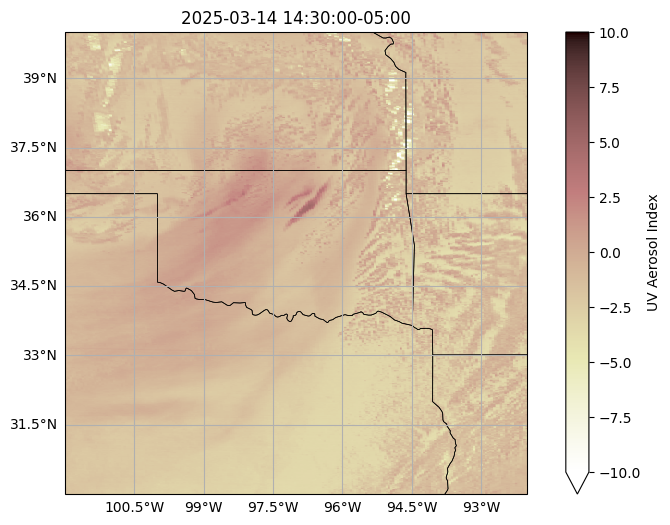

In [63]:
# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2025-03-14 14:30:00',tz='America/Chicago')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot = tempo_data_uvai_filtered['uv_aerosol_index'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('pink_r'), # color scale
    vmin=-10, # minimum value
    vmax=10, # maximum value
    cbar_kwargs={'label':'UV Aerosol Index'} # set colorbar label
)

ax.set_title(timestamp_local)

plt.show()

# Use Aerosol Index to Mask Features for Analysis

We will now use the UV Aerosol Index, as a rough indicator of the extent of the smoke plumes, to perform an analysis comparing trace gas concentrations in areas impacted by the smoke plumes with those outside.

## Combine the TEMPO data into a single Dataset

To facilitate the analysis, first, combine all the TEMPO Datasets you created into a single Dataset.

*Instructions*

* Write code which will combine each of the TEMPO Datasets into a single Dataset.

<details>

*Hint*: To merge multiple datasets together, use the following code example:

```
combined_dataset = xr.merge([dataset_1,dataset_2,dataset_3])
```

</details>

In [64]:
tempo_data = xr.merge([tempo_data_no2_filtered,tempo_data_hcho_filtered,tempo_data_uvai_filtered])

## Create a mask based on the UV Aerosol Index

Now, we will use the values of the UV Aerosol Index to create a mask, separating the smoke plume from other parts of the scene.

*Instructions*

* Use the plots of UV Aerosol Index you created above to seelct a value which seems to separate between smoke-impacted and non-smoke-impacted parts of the scene.

* Write code which will create a binary mask based on that value.

<details>

*Hint*: You can create a dataset which acts as a binary mask by setting it equal to a logical expression, such as an inequality. For example:

```
binary_mask = data > threshold
```

`binary_mask` will have value `True` wherever the values in `data` are above `threshold`.


</details>

In [72]:
tempo_data['uvai_mask'] = tempo_data['uv_aerosol_index'] > 2

## Plot the mask

Use the plot below to visualize your binary mask.

*Instructions*

* Modify the code below as needed to plot values of your binary mask.

* Try changing how your mask is defined in the above cell and re-plotting to determine what value of the mask seems reasonable.


<details>

*Hint*: The code assumes that `tempo_data[uvai_mask]` is the binary mask.

</details>

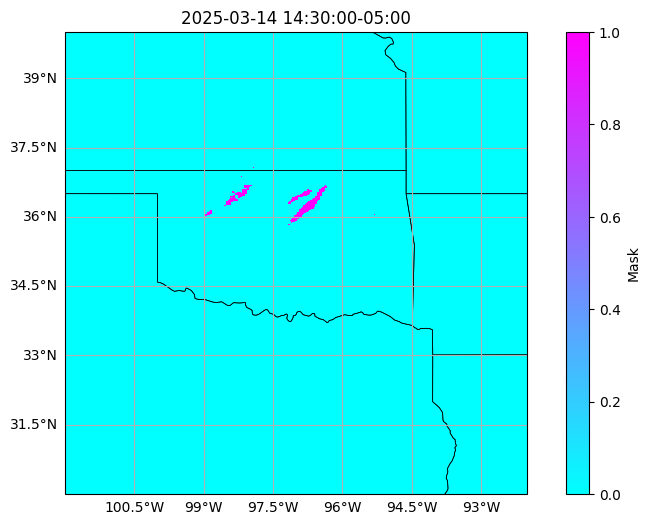

In [88]:
# Choose a timestamp to plot:
timestamp_local = pd.Timestamp('2025-03-14 14:30:00',tz='America/Chicago')

# Convert the timestamp from local time to UTC:
timestamp_utc = timestamp_local.tz_convert(tz='UTC').to_datetime64()

# Select the data to plot:
data_to_plot = tempo_data['uvai_mask'].sel(time=timestamp_utc,method='nearest')

# Plot the data on a map:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

data_to_plot.plot(
    ax=ax, # axis to add plot to
    cmap=plt.get_cmap('cool'), # color scale
    vmin=0, # minimum value
    vmax=1, # maximum value
    cbar_kwargs={'label':'Mask'} # set colorbar label
)

ax.set_title(timestamp_local)

plt.show()

## Use the mask to analyze a timeseries

We will now use the mask to seperate between smoke-impacted and non-smoke-impacted parts of the scene, and measure the average tropospheric NO2 between these areas.

*Instructions*

* In the beginning of this cell, write code to define three new data arrays:

  * `average_no2_overall` should be the spatial average tropospheric column NO2 across the entire region.

  * `average_no2_masked` should be the spatial average in regions where your binary mask for smoke is true.

  * `average_no2_unmasked` should be the spatial average in regions where your binary mask for smoke is false.

* Use the rest of the code in the cell to create a time-series plot of these three data arrays.

* Once you are satisfied, duplicate the cell and repeat the exercise for the Formaldehyde data.

<details>

*Hint*: To select only data where a mask is true, use this code example:

```
masked_data = data.where(binary_mask)
```

*Hint*: To select only data where a mask is false, use this code example:


```
unmasked_data = data.where(~binary_mask)
```

*Hint*: To spatially average data, you can take the mean value across the latitude and longitude dimensions, following this example:

```
spatially_averaged_data = data.mean(['latitude','longitude'])
```

*Huint*: You can create a new cell to test out new parts of the code you are writing before trying to run the plotting codes.

</details>

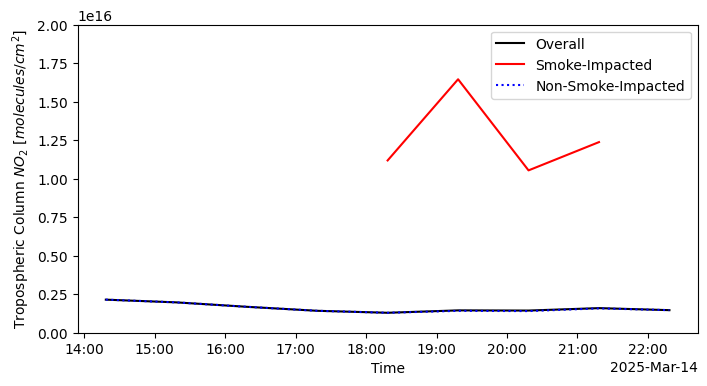

In [91]:
average_no2_overall = tempo_data['no2_vertical_column_troposphere'].mean(['latitude','longitude'])
average_no2_masked = tempo_data['no2_vertical_column_troposphere'].where(tempo_data['uvai_mask']).mean(['latitude','longitude'])
average_no2_unmasked = tempo_data['no2_vertical_column_troposphere'].where(~tempo_data['uvai_mask']).mean(['latitude','longitude'])

fig, ax = plt.subplots(figsize=(8, 4))

average_no2_overall.plot(ax=ax,label='Overall',color='black')
average_no2_masked.plot(ax=ax,label='Smoke-Impacted',color='red')
average_no2_unmasked.plot(ax=ax,label='Non-Smoke-Impacted',color='blue',linestyle=':')

ax.set_ylabel('Tropospheric Column $NO_2$ [$molecules/cm^2$]')
ax.set_xlabel('Time')
ax.set_ylim(0,20e15)
ax.legend()

plt.show()

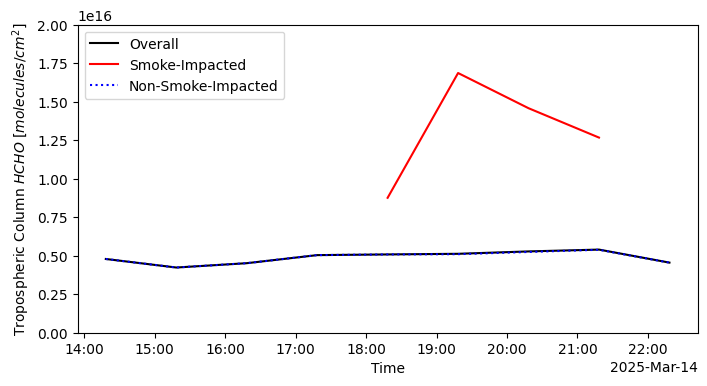

In [94]:
average_hcho_overall = tempo_data['hcho_vertical_column'].mean(['latitude','longitude'])
average_hcho_masked = tempo_data['hcho_vertical_column'].where(tempo_data['uvai_mask']).mean(['latitude','longitude'])
average_hcho_unmasked = tempo_data['hcho_vertical_column'].where(~tempo_data['uvai_mask']).mean(['latitude','longitude'])

fig, ax = plt.subplots(figsize=(8, 4))

average_hcho_overall.plot(ax=ax,label='Overall',color='black')
average_hcho_masked.plot(ax=ax,label='Smoke-Impacted',color='red')
average_hcho_unmasked.plot(ax=ax,label='Non-Smoke-Impacted',color='blue',linestyle=':')

ax.set_ylabel('Tropospheric Column $HCHO$ [$molecules/cm^2$]')
ax.set_xlabel('Time')
ax.set_ylim(0,20e15)
ax.legend()

plt.show()